# 4X User Study Analysis
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import datetime

from copy import deepcopy
from tqdm import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

/Users/kapilgarg/miniconda3/envs/les/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


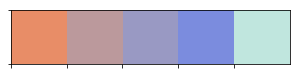

In [3]:
# defining colors
COLORS = {
    'ORANGE': '#E88D67',
    'PINK': '#BB999C',
    'VIOLET': '#9999C3',
    'BLUE': '#7B8CDE',
    'GREEN': '#C0E6DE'
}

# palette
sns.set_palette(COLORS.values())
sns.palplot(sns.color_palette())
sns.set(font_scale=1.5, style='whitegrid')

# Load in data

In [29]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

In [30]:
def load_data(base_url, header, data):
    """
    Loads in all needed tables from database, given url.
    
    Inputs: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in tqdm(collection_list):
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0:
            current_data['createdAt'] = (pd.to_datetime(current_data['createdAt']).astype(np.int64) // 10**9)
            current_data['updatedAt'] = (pd.to_datetime(current_data['updatedAt']).astype(np.int64) // 10**9)
        
        output[collection] = current_data
    
    return output

In [31]:
data_4x = load_data(url_4x, header, data)

100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


In [32]:
data_opp_location = load_data(url_opp_location, header, data)

100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


In [33]:
data_opp_distance = load_data(url_opp_distance, header, data)

100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


# Data Monitor
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper